# Hackathon

Some utilities

## Import Utils

In [ ]:
!pip install keras

In [1]:
import keras
import h5py as h5
import numpy as np
import pandas as pd

PATH_DATA = 'Untitled Folder/hackathon_data_train_eightieth.h5'
PATH_PREDICT_WITHOUT_GT = 'Untitled Folder/pred_eighties_from_full_1_without_gt.h5'
#PATH_SUBMIT = 'data/submit/pred_eighties_from_half_1_AWESOMEGROUP.h5'
#PATH_PREDICT_WITH_GT = 'data/pred_teachers/pred_eighties_from_half_1.h5'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [3]:
f = h5.File(PATH_DATA)

In [4]:
range(len(f['S2']))

range(0, 234000)

In [5]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [6]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = f['S2'][batch_idxs, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [7]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

In [8]:
train_gen = generator(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [9]:
idxs_test = get_idxs(PATH_PREDICT_WITHOUT_GT)

In [10]:
print(train_batch_count, val_batch_count)

5850 1463


# Instanciation du model

In [ ]:
#model 1
input_shape = (16,16,4)
model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(8,(5,5),activation='relu',input_shape =(16,16,4)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(8,(5,5),activation='relu',input_shape =(16,16,4)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(200,activation ='relu'))
model.add(Dropout(0.01))

model.add(Dense(23,activation ='softmax'))


In [41]:
#model 2
input_shape=(16,16,4)
model2 = Sequential()
model2.add(BatchNormalization(input_shape=input_shape))

model2.add(Conv2D(32, (5, 5), input_shape=input_shape))
model2.add(Activation('relu'))

model2.add(Conv2D(32, (5, 5)))
model2.add(Activation('relu'))

model2.add(Conv2D(32, (4, 4)))
model2.add(Activation('relu'))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))


model2.add(Flatten())
model2.add(Dense(64))
model2.add(Activation('relu'))
model2.add(Dropout(0.01))
model2.add(Dense(23))
model2.add(Activation('softmax'))

# Fit

In [38]:
# optim = keras.optimizers.Adam(lr=0.001)
optim = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model2.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model2.fit_generator(train_gen, steps_per_epoch=1000, epochs=6, verbose=1, validation_data=val_gen, nb_val_samples=100)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, steps_per_epoch=1000, validation_data=<generator..., epochs=6, validation_steps=100)`
  


Epoch 1/6
1000/1000 [==============================] - 46s 46ms/step - loss: 1.4994 - acc: 0.4694 - val_loss: 1.2303 - val_acc: 0.5403
Epoch 2/6
1000/1000 [==============================] - 45s 45ms/step - loss: 1.2577 - acc: 0.5248 - val_loss: 1.1740 - val_acc: 0.5472
Epoch 3/6
1000/1000 [==============================] - 45s 45ms/step - loss: 1.2189 - acc: 0.5372 - val_loss: 1.1699 - val_acc: 0.5519
Epoch 4/6
1000/1000 [==============================] - 45s 45ms/step - loss: 1.1970 - acc: 0.5425 - val_loss: 1.1564 - val_acc: 0.5428
Epoch 5/6
1000/1000 [==============================] - 45s 45ms/step - loss: 1.1917 - acc: 0.5450 - val_loss: 1.1535 - val_acc: 0.5669
Epoch 6/6
1000/1000 [==============================] - 46s 46ms/step - loss: 1.1816 - acc: 0.5510 - val_loss: 1.1611 - val_acc: 0.5487


<IPython.core.display.Javascript object>


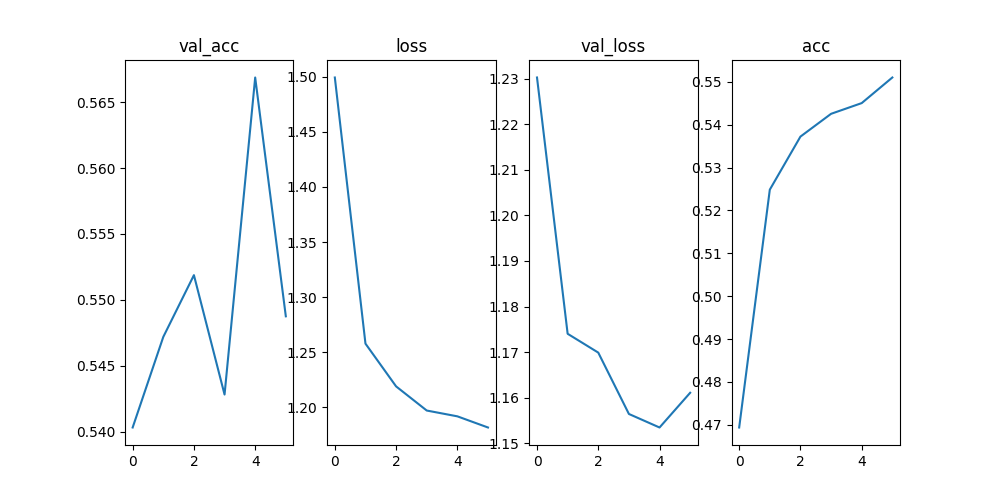

In [46]:
plt.figure(figsize=(10,5))

for i, (name, values) in enumerate(history.history.items()):
    plt.subplot(1, len(history.history.items()), i+1)
    plt.plot(values)
    plt.title(name)

## Prediction routines

In order to submit a result here are some gits

In [18]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

In [19]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model2.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(prediction)
#build_h5_pred_file(np.argmax(prediction, axis = 1), PATH_SUBMIT)

241700
7554/7554 [==============================] - 23s 3ms/step
[[[[  0.         0.        82.337296 ...   0.        69.35203
      0.      ]]]


 [[[  2.285851   0.        82.25529  ...   0.        65.80533
      0.      ]]]


 [[[  0.         0.        75.24576  ...   0.        88.919785
      0.      ]]]


 ...


 [[[ 18.389467   0.        69.427505 ...   0.       107.5595
      0.      ]]]


 [[[ 15.274645   0.        72.11559  ...   0.       107.82719
      0.      ]]]


 [[[ 14.930773   0.        77.01293  ...   0.       113.5976
      0.      ]]]]


In [20]:
def resultat_avec_csv(modele,name,path):

    pred_idx = get_idxs(path)
    pred_gen = prediction_generator(path, BATCH_SIZE, pred_idx)
    prediction = modele.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
    class_prediction = np.argmax(prediction, axis = 1)
    tosubmit = pd.DataFrame([pred_idx,class_prediction]).transpose()
    tosubmit.columns=["ID","TOP_LANDCOVER"]
    to_submit_csv = tosubmit.to_csv('%s.csv'%(name),sep=',',index= False)
    return prediction

def resultat(modele,path):

    pred_idx = get_idxs(path)
    pred_gen = prediction_generator(path, BATCH_SIZE, pred_idx)
    prediction = modele.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)


    return prediction

In [42]:
essai =resultat(model2,PATH_DATA)

7313/7313 [==============================] - 25s 3ms/step


In [39]:
resultat_avec_csv(model2,"jubois_palmi",PATH_PREDICT_WITHOUT_GT)

7554/7554 [==============================] - 26s 3ms/step


array([[9.9660211e-11, 8.4121279e-02, 3.4232554e-01, ..., 4.5173999e-04,
        4.6455093e-10, 2.8604871e-10],
       [1.7313005e-09, 1.1067322e-01, 3.2208198e-01, ..., 1.0815704e-03,
        6.5419901e-09, 4.2342156e-09],
       [3.0984508e-09, 1.3462625e-01, 3.0020055e-01, ..., 1.2697232e-03,
        1.0505762e-08, 7.1851631e-09],
       ...,
       [1.0479813e-12, 2.6873988e-01, 2.6513755e-01, ..., 1.5551517e-04,
        7.4793383e-12, 3.1750498e-12],
       [3.9770281e-13, 2.6727322e-01, 2.6300016e-01, ..., 1.1098615e-04,
        3.2056699e-12, 1.2805918e-12],
       [1.5598832e-14, 2.5929594e-01, 2.3904133e-01, ..., 3.0717980e-05,
        1.7301122e-13, 6.0752808e-14]], dtype=float32)

## Some ideas for monitoring

In [23]:
7700/32


240.625

In [24]:
def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    print(batch_count)
    for b in range(batch_count):
        if (b+1)*batch_size<
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        print(max(batch_idxs))
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

gt_gen = gt_generator(PATH_DATA, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

SyntaxError: invalid syntax (<ipython-input-24-903c278e97ce>, line 7)

In [31]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' #if normalize else '.i'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
def clean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes

In [43]:
list_top=list(f['TOP_LANDCOVER'])

Normalized confusion matrix


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


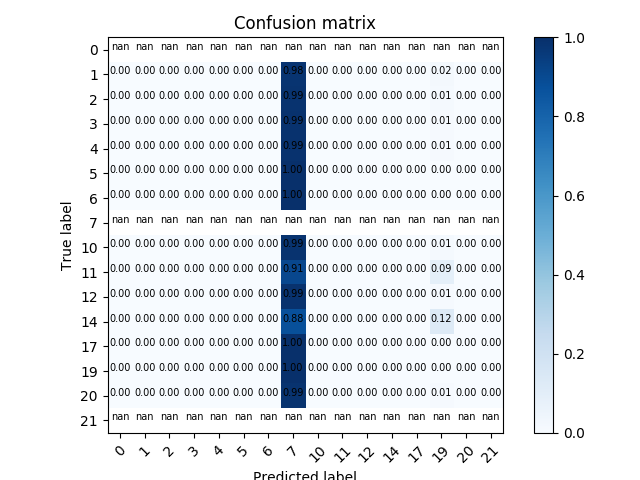

/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


In [44]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
y_true = np.array(list_top)
y_pred = np.argmax(essai, axis = 1)

real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=True)

In [29]:
list_top[:20][0][0]

12.0

In [ ]:
len(list_top)